### IMPORTS 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

### HELPER FUNCTION

In [5]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

### LOAD THE DATA CSV  FILE

In [6]:

path = "/Users/pavan/Desktop/ai 2nd pro"
csvfile = os.path.join(path,"CSC215_P2_Stock_Price.csv") 
df_stock = pd.read_csv(csvfile)

#print first and last 5 rows in new csv file
print(df_stock.head())
print(df_stock.tail())

print("\nNumber of columns and row currently:")
print("Data: ", df_stock.shape)


        Date      Open      High       Low     Close  Adj_Close   Volume
0  2000/3/27  3.812500  4.156250  3.812500  4.125000   4.125000  3675600
1  2000/3/28  4.125000  4.125000  4.000000  4.015625   4.015625  1077600
2  2000/3/29  4.000000  4.031250  3.953125  4.000000   4.000000   437200
3  2000/3/30  4.000000  4.000000  3.843750  3.843750   3.843750  1883600
4  2000/3/31  3.734375  3.734375  3.390625  3.390625   3.390625  7931600
          Date        Open        High         Low       Close   Adj_Close  \
4387  2017/9/1  113.790001  114.099998  112.790001  113.309998  113.309998   
4388  2017/9/5  112.519997  113.529999  111.160004  111.870003  111.870003   
4389  2017/9/6  112.029999  112.489998  110.250000  112.230003  112.230003   
4390  2017/9/7  112.459999  112.900002  112.000000  112.339996  112.339996   
4391  2017/9/8  112.300003  114.790001  112.010002  113.190002  113.190002   

       Volume  
4387   950000  
4388  1805200  
4389  2136700  
4390  1251600  
4391  1611700

## Drop missing values and columns 

In [7]:
# Storing in a different dataframe before dropping the columns
df_newstock= df_stock

# Drop rows if there are any missing values
df_newstock.isnull().all(axis=1)
df_newstock = df_newstock.dropna()

# Dropping the columns Date and Adj_Close as mentioned
df_newstock=df_newstock.drop(['Date', 'Adj_Close'], axis=1)

#print first 5 rows in new csv file
print(df_newstock.head())

#data about count of NaN in each column
print(df_newstock.isnull().sum())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close   Volume
0  3.812500  4.156250  3.812500  4.125000  3675600
1  4.125000  4.125000  4.000000  4.015625  1077600
2  4.000000  4.031250  3.953125  4.000000   437200
3  4.000000  4.000000  3.843750  3.843750  1883600
4  3.734375  3.734375  3.390625  3.390625  7931600
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Number of col/row currently:
Data:  (4392, 5)


In [8]:
# creating a copy of the column, Close
df_newstock['y'] = df_newstock['Close']
#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close   Volume         y
0  3.812500  4.156250  3.812500  4.125000  3675600  4.125000
1  4.125000  4.125000  4.000000  4.015625  1077600  4.015625
2  4.000000  4.031250  3.953125  4.000000   437200  4.000000
3  4.000000  4.000000  3.843750  3.843750  1883600  3.843750
4  3.734375  3.734375  3.390625  3.390625  7931600  3.390625

Number of col/row currently:
Data:  (4392, 6)


### NORMALIZE NUMERICAL FEATURES

In [9]:


#Normalizing except  last column y
for column in df_newstock.columns:
  if  column != 'y':
    encode_numeric_zscore(df_newstock, column)

#print first  5 rows in new csv file to check for normalizing
print(df_newstock.head())

       Open      High       Low     Close    Volume         y
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625


In [10]:
# Set all column other than y as input or 'x'
x = df_newstock.iloc[:,df_newstock.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_newstock['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


In [11]:
def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [12]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array
x_newseq=x_lstseq.reshape(4385,7,5)

#print("Shape of x_newseq: {}".format(y_lstm_seq_test.shape))
print("Shape of x_newseq: {}".format(x_newseq.shape))


Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)
Shape of x_newseq: (4385, 7, 5)


### Split train and test date 70/30

In [13]:
##Split train and test date 70/30
x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)

print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)


Shape of x_train :(3069, 7, 5)
Shape of x_test  :(1316, 7, 5)
Shape of y_train :(3069,)
Shape of y_test  :(1316,)


(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

###  LSTM

Optimizer  used:  adam  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: 1306.9316 - val_loss: 381.0853
Epoch 2/200
3069/3069 - 2s - loss: 257.1885 - val_loss: 67.3783
Epoch 3/200
3069/3069 - 2s - loss: 37.1260 - val_loss: 13.2349
Epoch 4/200
3069/3069 - 2s - loss: 15.9033 - val_loss: 5.3571
Epoch 5/200
3069/3069 - 2s - loss: 11.1393 - val_loss: 4.0449
Epoch 6/200
3069/3069 - 2s - loss: 10.4371 - val_loss: 2.9824
Epoch 7/200
3069/3069 - 2s - loss: 8.7805 - val_loss: 2.9120
Epoch 8/200
3069/3069 - 2s - loss: 8.9930 - val_loss: 3.2116
Epoch 9/200
3069/3069 - 2s - loss: 7.3262 - val_loss: 2.8918
Epoch 10/200
3069/3069 - 2s - loss: 7.5471 - val_loss: 2.5848
Epoch 11/200
3069/3069 - 2s - loss: 6.4528 - val_loss: 2.6688
Epoch 12/200
3069/3069 - 2s - loss: 6.2751 - val_loss: 1.8767
Epoch 13/200
3069/3069 - 2s - loss: 6.8554 - val_loss: 2.7153
Epoch 14/200
3069/3069 - 2s - loss: 6.8385 - val_loss: 2.2646
Epoch 15/200
3069/3069 

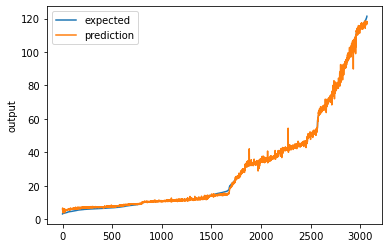

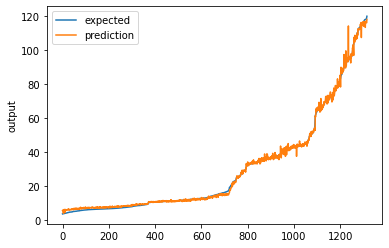

Optimizer  used:  adam  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: 1701.4873 - val_loss: 1563.3073
Epoch 2/200
3069/3069 - 2s - loss: 1537.6485 - val_loss: 1456.6493
Epoch 3/200
3069/3069 - 2s - loss: 1436.9595 - val_loss: 1360.5760
Epoch 4/200
3069/3069 - 2s - loss: 1343.2640 - val_loss: 1270.6386
Epoch 5/200
3069/3069 - 2s - loss: 1256.2362 - val_loss: 1193.9438
Epoch 6/200
3069/3069 - 2s - loss: 1187.1657 - val_loss: 1134.6621
Epoch 7/200
3069/3069 - 2s - loss: 1131.3895 - val_loss: 1084.3746
Epoch 8/200
3069/3069 - 2s - loss: 1084.9646 - val_loss: 1043.6439
Epoch 9/200
3069/3069 - 2s - loss: 1041.1742 - val_loss: 999.0174
Epoch 10/200
3069/3069 - 2s - loss: 1000.8222 - val_loss: 966.8075
Epoch 11/200
3069/3069 - 2s - loss: 972.7907 - val_loss: 944.0690
Epoch 12/200
3069/3069 - 2s - loss: 952.1900 - val_loss: 927.2853
Epoch 13/200
3069/3069 - 2s - loss: 936.8877 - val_loss: 915.0657
Epoch 14/200
3069/3069 - 

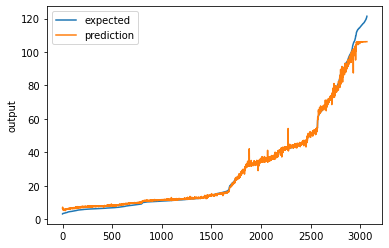

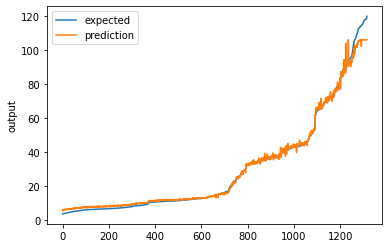

Optimizer  used:  adam  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 1556.7874 - val_loss: 1325.4919
Epoch 2/200
3069/3069 - 2s - loss: 1280.7326 - val_loss: 1193.1477
Epoch 3/200
3069/3069 - 2s - loss: 1169.0438 - val_loss: 1101.6096
Epoch 4/200
3069/3069 - 2s - loss: 1058.0196 - val_loss: 973.5398
Epoch 5/200
3069/3069 - 2s - loss: 951.9127 - val_loss: 882.0530
Epoch 6/200
3069/3069 - 2s - loss: 863.6988 - val_loss: 798.3961
Epoch 7/200
3069/3069 - 2s - loss: 785.2860 - val_loss: 726.7147
Epoch 8/200
3069/3069 - 2s - loss: 716.9997 - val_loss: 663.9872
Epoch 9/200
3069/3069 - 2s - loss: 657.0752 - val_loss: 608.5892
Epoch 10/200
3069/3069 - 2s - loss: 603.9098 - val_loss: 559.3496
Epoch 11/200
3069/3069 - 2s - loss: 557.0060 - val_loss: 516.9760
Epoch 12/200
3069/3069 - 2s - loss: 515.0814 - val_loss: 476.3266
Epoch 13/200
3069/3069 - 2s - loss: 476.5479 - val_loss: 440.7170
Epoch 14/200
3069/3069 - 2s - loss: 442

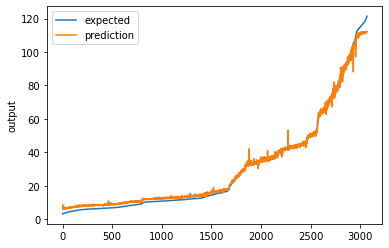

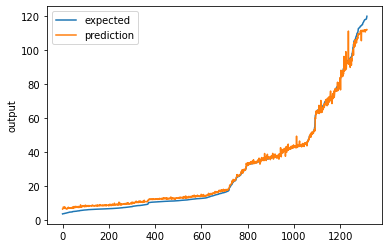

Optimizer  used:  sgd  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 6s - loss: nan - val_loss: nan
Epoch 2/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Score_train (RMSE): 17.032480239868164
Score_test (RMSE): 16.479135513305664


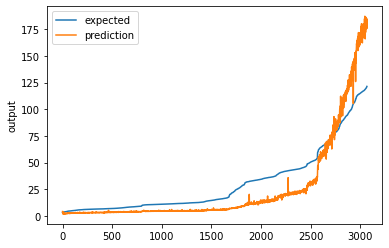

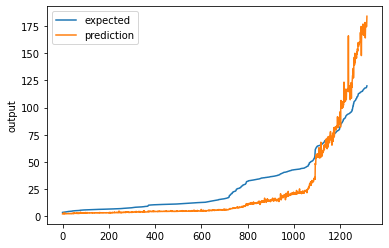

Optimizer  used:  sgd  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 232.0842 - val_loss: 22.4485
Epoch 2/200
3069/3069 - 2s - loss: 52.3843 - val_loss: 12.3910
Epoch 3/200
3069/3069 - 2s - loss: 20.0300 - val_loss: 4.4988
Epoch 4/200
3069/3069 - 2s - loss: 11.8851 - val_loss: 6.1970
Epoch 5/200
3069/3069 - 2s - loss: 11.9013 - val_loss: 3.4407
Epoch 6/200
3069/3069 - 2s - loss: 10.7951 - val_loss: 6.2022
Epoch 7/200
3069/3069 - 2s - loss: 7.4245 - val_loss: 2.2219
Epoch 8/200
3069/3069 - 2s - loss: 7.4570 - val_loss: 10.5749
Epoch 9/200
3069/3069 - 2s - loss: 8.0514 - val_loss: 2.2836
Epoch 10/200
3069/3069 - 2s - loss: 8.7381 - val_loss: 5.2698
Epoch 11/200
3069/3069 - 3s - loss: 7.1534 - val_loss: 2.4046
Epoch 12/200
3069/3069 - 3s - loss: 6.1634 - val_loss: 5.2976
Epoch 00012: early stopping
Score_train (RMSE): 1.4300123453140259
Score_test (RMSE): 1.4905964136123657


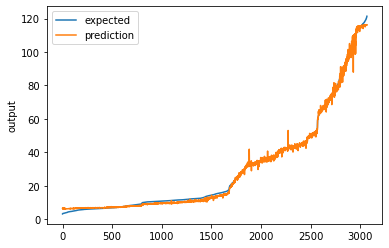

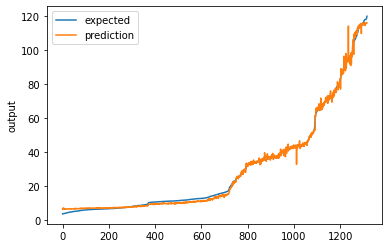

Optimizer  used:  sgd  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 387.1759 - val_loss: 34.5085
Epoch 2/200
3069/3069 - 2s - loss: 40.7818 - val_loss: 21.9635
Epoch 3/200
3069/3069 - 2s - loss: 19.8833 - val_loss: 30.8769
Epoch 4/200
3069/3069 - 2s - loss: 16.4528 - val_loss: 27.0302
Epoch 5/200
3069/3069 - 2s - loss: 14.2284 - val_loss: 3.8390
Epoch 6/200
3069/3069 - 2s - loss: 11.9115 - val_loss: 6.2382
Epoch 7/200
3069/3069 - 2s - loss: 9.2667 - val_loss: 4.9461
Epoch 8/200
3069/3069 - 2s - loss: 8.5365 - val_loss: 2.7850
Epoch 9/200
3069/3069 - 2s - loss: 9.4533 - val_loss: 5.1294
Epoch 10/200
3069/3069 - 3s - loss: 10.1697 - val_loss: 2.7839
Epoch 11/200
3069/3069 - 2s - loss: 10.2648 - val_loss: 5.6983
Epoch 12/200
3069/3069 - 2s - loss: 7.4574 - val_loss: 3.0930
Epoch 13/200
3069/3069 - 2s - loss: 9.4384 - val_loss: 11.2625
Epoch 14/200
3069/3069 - 2s - loss: 7.2816 - val_loss: 2.4136
Epoch 15/200
3069/3069 

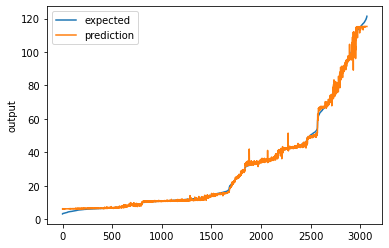

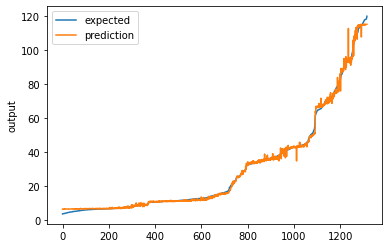

In [15]:
# List of posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)
    
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(32,activation=activ_function))
    model.add(Dense(1))
    
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
    model.load_weights('best_weights_LSTM.hdf5')
    
    pred_train = model.predict(x_train)
    score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
    print("Score_train (RMSE): {}".format(score_train))

    pred_test = model.predict(x_test)
    score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
    print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True) 

Optimizer  used:  adam  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: 1349.6862 - val_loss: 651.9914
Epoch 2/200
3069/3069 - 2s - loss: 392.7693 - val_loss: 153.4078
Epoch 3/200
3069/3069 - 2s - loss: 91.9358 - val_loss: 34.1747
Epoch 4/200
3069/3069 - 2s - loss: 28.8503 - val_loss: 10.2263
Epoch 5/200
3069/3069 - 2s - loss: 14.8019 - val_loss: 5.2872
Epoch 6/200
3069/3069 - 2s - loss: 10.7581 - val_loss: 3.4978
Epoch 7/200
3069/3069 - 2s - loss: 9.4783 - val_loss: 2.6692
Epoch 8/200
3069/3069 - 2s - loss: 8.3540 - val_loss: 3.6427
Epoch 9/200
3069/3069 - 2s - loss: 7.9952 - val_loss: 2.3859
Epoch 10/200
3069/3069 - 2s - loss: 6.8671 - val_loss: 3.3222
Epoch 11/200
3069/3069 - 2s - loss: 7.1381 - val_loss: 3.2147
Epoch 12/200
3069/3069 - 2s - loss: 6.0327 - val_loss: 3.2857
Epoch 13/200
3069/3069 - 2s - loss: 6.2489 - val_loss: 2.3497
Epoch 14/200
3069/3069 - 2s - loss: 6.3749 - val_loss: 2.4347
Epoch 15/200
3069/306

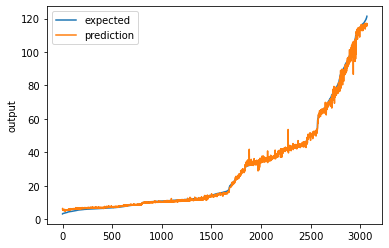

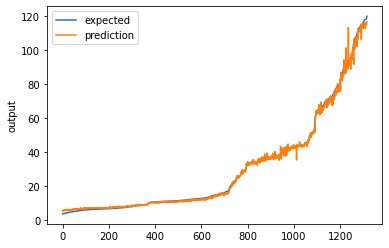

Optimizer  used:  adam  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: 1599.5579 - val_loss: 1427.8336
Epoch 2/200
3069/3069 - 2s - loss: 1402.7370 - val_loss: 1325.5623
Epoch 3/200
3069/3069 - 2s - loss: 1309.6569 - val_loss: 1242.8356
Epoch 4/200
3069/3069 - 2s - loss: 1233.1759 - val_loss: 1174.5640
Epoch 5/200
3069/3069 - 2s - loss: 1169.1885 - val_loss: 1117.2779
Epoch 6/200
3069/3069 - 2s - loss: 1113.5261 - val_loss: 1065.6132
Epoch 7/200
3069/3069 - 2s - loss: 1037.0657 - val_loss: 960.8397
Epoch 8/200
3069/3069 - 2s - loss: 952.2405 - val_loss: 893.7565
Epoch 9/200
3069/3069 - 2s - loss: 886.6634 - val_loss: 832.4258
Epoch 10/200
3069/3069 - 2s - loss: 827.1006 - val_loss: 776.0114
Epoch 11/200
3069/3069 - 2s - loss: 773.0359 - val_loss: 725.3477
Epoch 12/200
3069/3069 - 2s - loss: 723.9291 - val_loss: 679.1146
Epoch 13/200
3069/3069 - 2s - loss: 679.1403 - val_loss: 637.0695
Epoch 14/200
3069/3069 - 2s - 

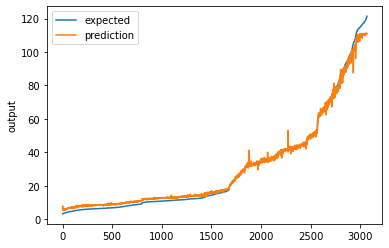

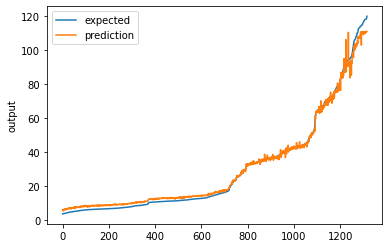

Optimizer  used:  adam  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: 1558.9015 - val_loss: 1319.8620
Epoch 2/200
3069/3069 - 2s - loss: 1277.1824 - val_loss: 1191.0874
Epoch 3/200
3069/3069 - 2s - loss: 1156.3953 - val_loss: 1067.9189
Epoch 4/200
3069/3069 - 2s - loss: 1041.4716 - val_loss: 965.1772
Epoch 5/200
3069/3069 - 2s - loss: 944.3172 - val_loss: 875.2647
Epoch 6/200
3069/3069 - 2s - loss: 858.8723 - val_loss: 795.5460
Epoch 7/200
3069/3069 - 2s - loss: 782.9521 - val_loss: 726.3330
Epoch 8/200
3069/3069 - 3s - loss: 716.2345 - val_loss: 663.9086
Epoch 9/200
3069/3069 - 2s - loss: 656.9490 - val_loss: 609.9480
Epoch 10/200
3069/3069 - 2s - loss: 604.6263 - val_loss: 561.3149
Epoch 11/200
3069/3069 - 2s - loss: 558.2462 - val_loss: 517.1828
Epoch 12/200
3069/3069 - 2s - loss: 516.2216 - val_loss: 478.6703
Epoch 13/200
3069/3069 - 2s - loss: 478.2237 - val_loss: 443.6671
Epoch 14/200
3069/3069 - 2s - loss: 443

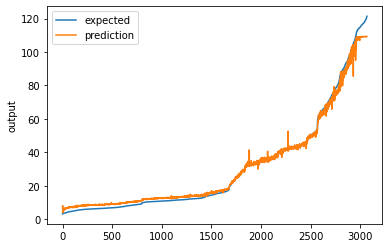

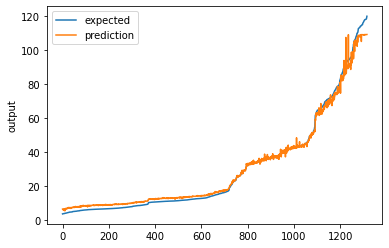

Optimizer  used:  sgd  Activation Function used :  relu
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 304.3355 - val_loss: 59.7253
Epoch 2/200
3069/3069 - 1s - loss: 29.1470 - val_loss: 46.0012
Epoch 3/200
3069/3069 - 2s - loss: 30.0071 - val_loss: 5.9562
Epoch 4/200
3069/3069 - 2s - loss: 32.8940 - val_loss: 13.1566
Epoch 5/200
3069/3069 - 2s - loss: 25.6305 - val_loss: 8.1919
Epoch 6/200
3069/3069 - 2s - loss: 22.0165 - val_loss: 32.8359
Epoch 7/200
3069/3069 - 2s - loss: 14.6086 - val_loss: 3.1404
Epoch 8/200
3069/3069 - 2s - loss: 13.8864 - val_loss: 4.4030
Epoch 9/200
3069/3069 - 2s - loss: 18.0093 - val_loss: 3.7777
Epoch 10/200
3069/3069 - 2s - loss: 15.2251 - val_loss: 2.4240
Epoch 11/200
3069/3069 - 2s - loss: 11.4274 - val_loss: 5.7551
Epoch 12/200
3069/3069 - 2s - loss: 11.3481 - val_loss: 5.1236
Epoch 13/200
3069/3069 - 2s - loss: 11.1347 - val_loss: 9.0435
Epoch 14/200
3069/3069 - 2s - loss: 15.4648 - val_loss: 2.8353
Epoch 15/200
3069/

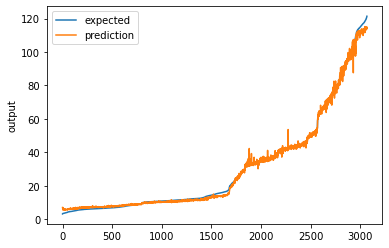

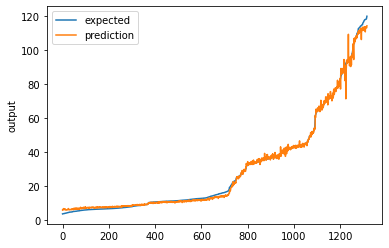

Optimizer  used:  sgd  Activation Function used :  sigmoid
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 149.9192 - val_loss: 15.7587
Epoch 2/200
3069/3069 - 2s - loss: 18.2245 - val_loss: 47.3825
Epoch 3/200
3069/3069 - 1s - loss: 14.7636 - val_loss: 6.0350
Epoch 4/200
3069/3069 - 2s - loss: 9.4252 - val_loss: 3.8962
Epoch 5/200
3069/3069 - 2s - loss: 10.6126 - val_loss: 7.2977
Epoch 6/200
3069/3069 - 2s - loss: 7.2849 - val_loss: 3.5060
Epoch 7/200
3069/3069 - 2s - loss: 6.5416 - val_loss: 3.5206
Epoch 8/200
3069/3069 - 2s - loss: 7.0430 - val_loss: 2.2212
Epoch 9/200
3069/3069 - 2s - loss: 7.4677 - val_loss: 4.3631
Epoch 10/200
3069/3069 - 2s - loss: 5.3200 - val_loss: 3.9874
Epoch 11/200
3069/3069 - 2s - loss: 5.7397 - val_loss: 6.6809
Epoch 12/200
3069/3069 - 2s - loss: 5.4495 - val_loss: 3.2068
Epoch 13/200
3069/3069 - 2s - loss: 4.8828 - val_loss: 5.3994
Epoch 00013: early stopping
Score_train (RMSE): 1.4698436260223389
Score_test (RMSE): 1.4

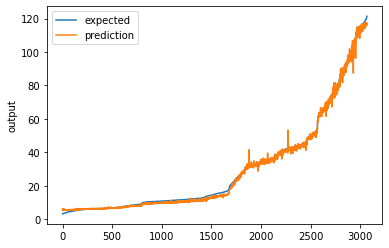

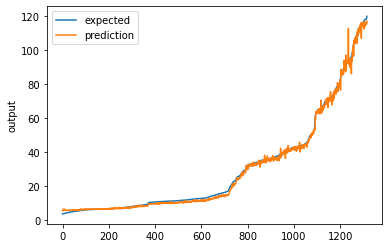

Optimizer  used:  sgd  Activation Function used :  tanh
Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 190.0996 - val_loss: 15.3246
Epoch 2/200
3069/3069 - 2s - loss: 20.7743 - val_loss: 7.5316
Epoch 3/200
3069/3069 - 2s - loss: 12.9758 - val_loss: 6.2050
Epoch 4/200
3069/3069 - 2s - loss: 9.2130 - val_loss: 4.5858
Epoch 5/200
3069/3069 - 2s - loss: 9.8890 - val_loss: 3.7040
Epoch 6/200
3069/3069 - 2s - loss: 9.0335 - val_loss: 5.1346
Epoch 7/200
3069/3069 - 2s - loss: 8.9828 - val_loss: 5.4960
Epoch 8/200
3069/3069 - 2s - loss: 9.5554 - val_loss: 3.8110
Epoch 9/200
3069/3069 - 2s - loss: 7.2420 - val_loss: 5.2966
Epoch 10/200
3069/3069 - 2s - loss: 7.6825 - val_loss: 2.6935
Epoch 11/200
3069/3069 - 2s - loss: 7.4710 - val_loss: 3.3268
Epoch 12/200
3069/3069 - 2s - loss: 7.0443 - val_loss: 8.2165
Epoch 13/200
3069/3069 - 2s - loss: 7.5415 - val_loss: 3.1097
Epoch 14/200
3069/3069 - 2s - loss: 7.6417 - val_loss: 5.4294
Epoch 15/200
3069/3069 - 2s - lo

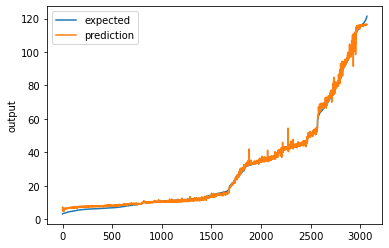

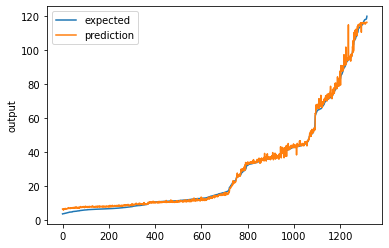

In [12]:
# List of posible activation functions
activation_functions = ['relu','sigmoid','tanh']
# List of posible optimizers
optimizers = ['adam','sgd']

# Loop through all combination of optimizers and activation functions
for optimizer in optimizers:
  for activ_function in activation_functions:
    print("Optimizer  used: ", optimizer, " Activation Function used : ", activ_function)
    
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32,activation=activ_function))
    #model.add(Dense(32,activation=activ_function))
    model.add(Dense(1))
    
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)
    
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
    model.load_weights('best_weights_LSTM.hdf5')
    
    pred_train = model.predict(x_train)
    score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
    print("Score_train (RMSE): {}".format(score_train))

    pred_test = model.predict(x_test)
    score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
    print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
    chart_regression(pred_train.flatten(),y_train, sort=True)
    chart_regression(pred_test.flatten(),y_test, sort=True) 